# Часть 1. Vanilla Autoencoder (10 баллов)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import os
import pandas as pd
from copy import deepcopy
import skimage.io
from skimage.transform import resize
from IPython.display import clear_output


%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    # all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_photos = np.stack(all_photos.values).astype(np.float32) # добавил конвертацию  в float32
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.8, shuffle=True)

In [ ]:
batch_size = 32
train_loader = DataLoader(np.rollaxis(train_data, 3, 1), batch_size=batch_size)
val_loader = DataLoader(np.rollaxis(val_data, 3, 1), batch_size=batch_size)

In [ ]:
# Проверим тип
train_loader_item = next(iter(train_loader))
print(f"Type: {type(train_loader_item)}")
print(f"tensor type: {train_loader_item.dtype}")


Type: <class 'torch.Tensor'>
tensor type: torch.float32


In [ ]:
def change_dims(img):
    if img.shape[0] == 3:
        return np.rollaxis(img, 0, 3)
    elif img.shape[0] == 1:
        return img[0]
    return img

In [ ]:
def show_images(rows_numb, cols_numb, line_1, title_1=None, line_2=[], title_2=None,  plt_title=None, size_x =10, size_y= 5):
    plt.figure(figsize=(size_x, size_y))
    if len(line_2) != 0:
        for i in range(cols_numb):
            plt.subplot(rows_numb, cols_numb, i + 1)
            plt.axis("off")
            plt.imshow(change_dims(line_1[i]))
            if title_1 is not None:
                plt.title(title_1)

            plt.subplot(rows_numb, cols_numb, i + cols_numb + 1)
            plt.imshow(change_dims(line_2[i]))
            if title_2 is not None:
                plt.title(title_2)
            plt.axis('off')
    else:
        for i in range(rows_numb * cols_numb):
            plt.subplot(rows_numb, cols_numb, i + 1)
            plt.axis("off")
            plt.imshow(change_dims(line_1[i]))
            if title_1 is not None:
                plt.title(title_1)
            plt.axis('off')
    if plt_title:
        plt.suptitle(plt_title)
    plt.show()

Посмотрим на картинки

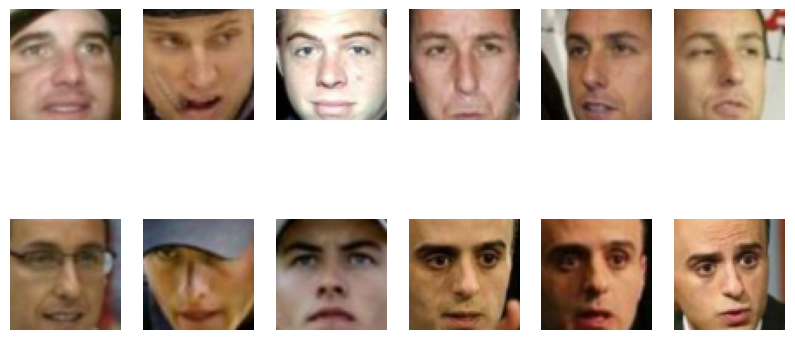

In [ ]:
show_images(2, 6, data[66:78])

In [ ]:
dim_code = 128 #  выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int = 128):
        super().__init__()

        # <определите архитектуры encoder и decoder>
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.encoder_fc = nn.Linear(64 * 64 * 64, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 64 * 64 * 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
        )

    def encode(self, x):
        latent_code = self.encoder_conv(x)
        latent_code = self.encoder_flatten(latent_code)
        latent_code = self.encoder_fc(latent_code)
        return latent_code

    def decode(self, x):
        reconstruction = self.decoder_fc(x)
        reconstruction = reconstruction.view(-1, 64, 64, 64)
        reconstruction = self.decoder(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3) # Ваш любимый оптимизатор

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
max_epochs = 55

In [ ]:
def train_autoencoder(train_loader, val_loader, autoencoder, criterion, optimizer, scheduler, epochs):
    train_losses, val_losses = [], []

    if torch.cuda.is_available():
        autoencoder.cuda()

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch + 1, epochs))
        avg_train_loss = 0.0

        autoencoder.train()
        for X_batch in train_loader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            reconstructed, _ = autoencoder(X_batch)
            loss = criterion(reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item() / len(train_loader)

        train_losses.append(avg_train_loss)

        avg_val_loss = 0.0
        autoencoder.eval()
        with torch.no_grad():
            for X_batch in val_loader:
                X_batch = X_batch.to(device)
                reconstructed, _ = autoencoder(X_batch)
                val_loss = criterion(reconstructed, X_batch)
                avg_val_loss += val_loss.item() / len(val_loader)

        val_losses.append(avg_val_loss)
        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        show_images(2, 5, X_batch[:5].cpu().numpy(), "real", reconstructed[:5].cpu().numpy(), "reconstr.", plt_title='%d / %d - loss: %f' % (epoch + 1, epochs, avg_train_loss))

        plt.figure(figsize=(20, 10))
        plt.plot(range(1, epoch + 2), train_losses, label="train_loss")
        plt.plot(range(1, epoch + 2), val_losses, label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

        del X_batch
        del reconstructed
        del loss
        del val_loss
        torch.cuda.empty_cache()

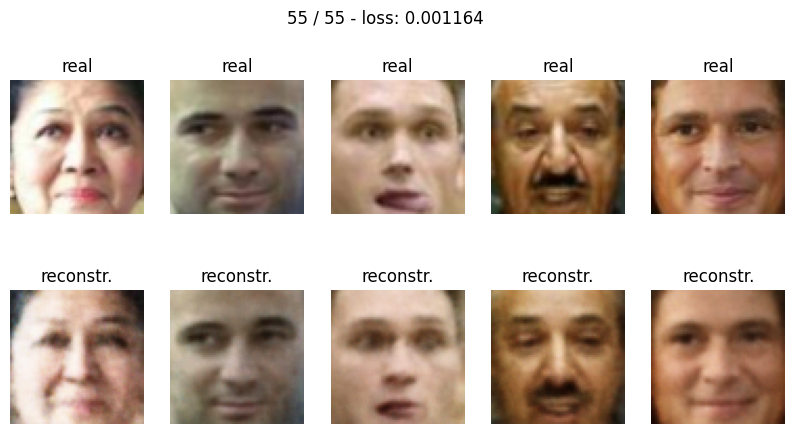

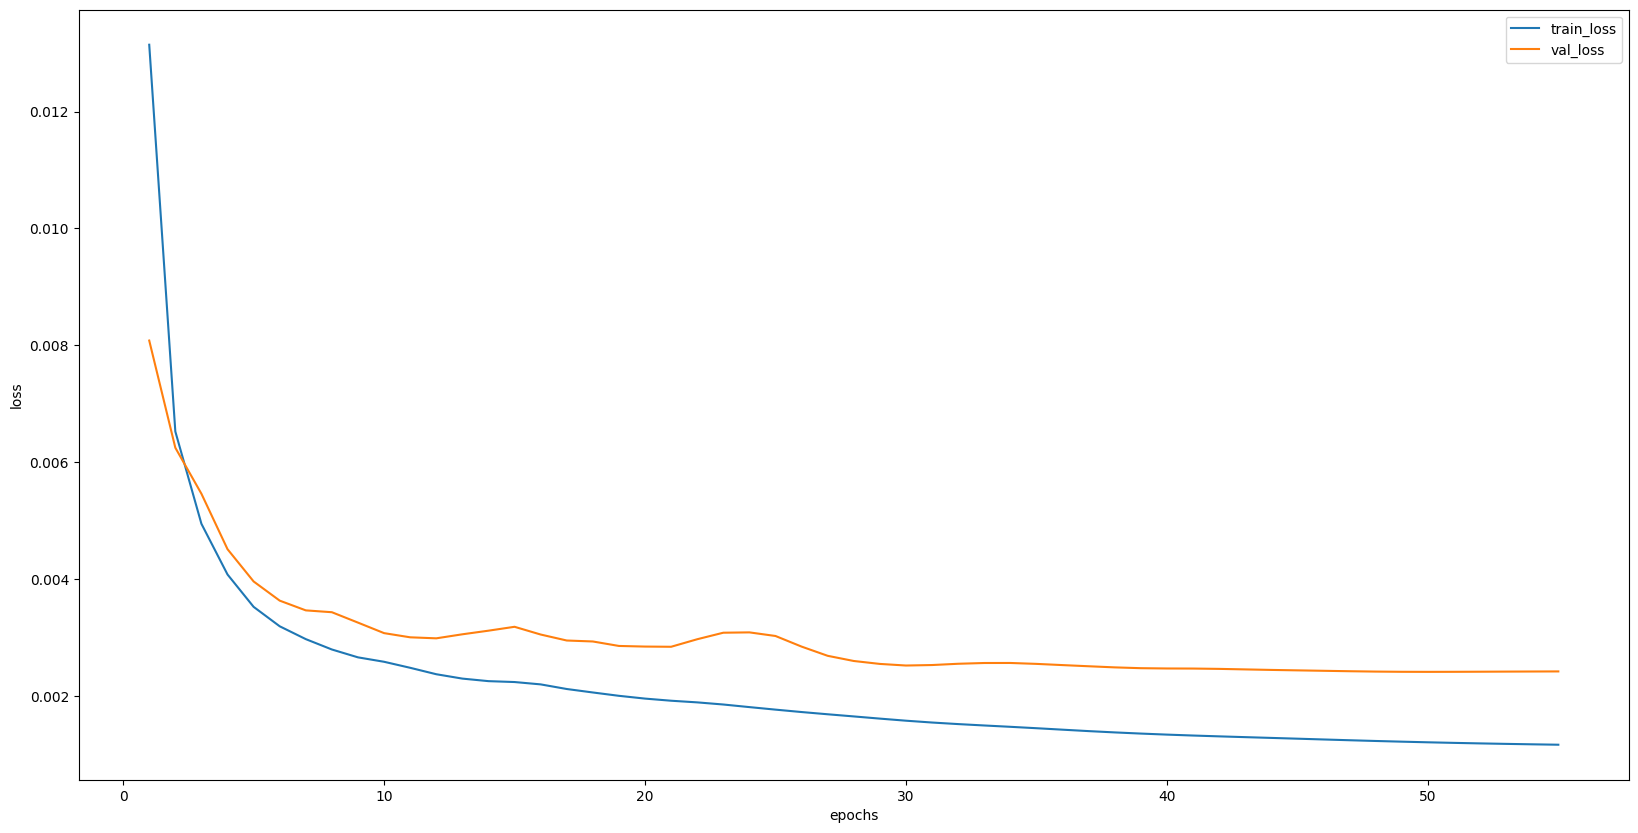

In [ ]:
# Тренировка автоэнкодера
train_autoencoder(train_loader, val_loader, autoencoder, criterion, optimizer, scheduler, max_epochs)

In [ ]:
def predict(autoencoder, val_loader):
    reconstructions, latent_outputs = [], []
    autoencoder.eval()
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            reconstructed, latent_output = autoencoder(X_batch)
            reconstructions.append(reconstructed.cpu())
            latent_outputs.append(latent_output.cpu())

    return torch.cat(reconstructions), torch.cat(latent_outputs)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# выведем первые Х картинок и их реконструкций из val выборки на экран
reconstructed, latent_outputs = predict(autoencoder, val_loader)
real_data = next(iter(val_loader))

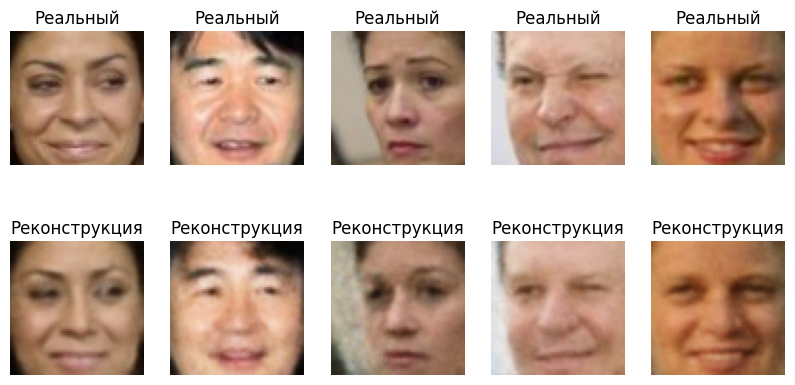

In [ ]:
show_images(2, 5, real_data[14:19].numpy(), "Реальный", reconstructed[14:19].numpy(), "Реконструкция")

Not bad, right?  Not bad.

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

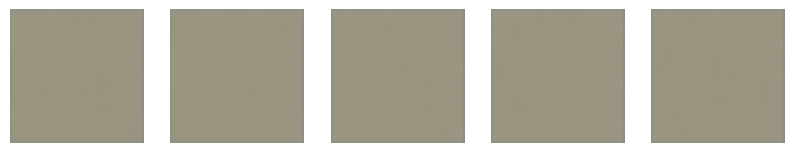

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
z = torch.tensor(z, dtype=torch.float32).to(device)

with torch.no_grad():
    output = autoencoder.decode(z).cpu()

#выведем полученные картинки
show_images(1, 5, output[:5].numpy())

Ожидаемо не работает.     
Подсчитаем mu и sigma на основе полученных из автоэнкодера латентных векторов. И попробуем сгенерировать векторы из нормального распределения на их основе.

In [ ]:
mu = torch.mean(latent_outputs, 0)
sigma = torch.std(latent_outputs, 0)

In [ ]:
z = torch.cat([(mu + (torch.randn_like(sigma) * sigma)).view(1, -1) for _ in range(25)]).to(device)

In [ ]:
autoencoder.eval()
with torch.no_grad():
    random_samples = autoencoder.decode(z).cpu()

Попробуем сгенерировать. Результат  похож на лица:

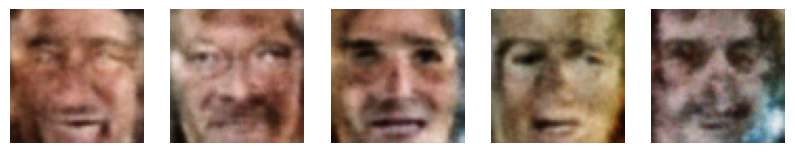

In [ ]:
show_images(1, 5, random_samples[:5].numpy())

Ожидаемо, что обычный автоэнкодер недостаточно хорошо выполняет задачу генерации. Хотя на лица результат похож.

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Изучим данные:

In [ ]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

Вуаля! Вы восхитительны!

In [ ]:
smiling_id = attrs['Smiling'].sort_values(ascending=False).head(20).index.values
smiling_data = data[smiling_id]

not_smiling_id = attrs['Smiling'].sort_values(ascending=False).tail(20).index.values
not_smiling_data = data[not_smiling_id]

# дополнительно поэкспериментируем с усами
mustache_id = attrs['Mustache'].sort_values(ascending=False).head(40).index.values
mustache_data = data[mustache_id]

not_mustache_id = attrs['Mustache'].sort_values(ascending=False).tail(40).index.values
not_mustache_data = data[not_mustache_id]

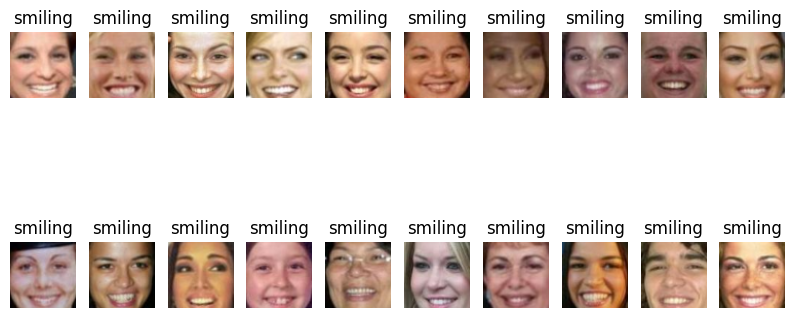

In [ ]:
show_images(2, 10, smiling_data[0:20], "smiling")

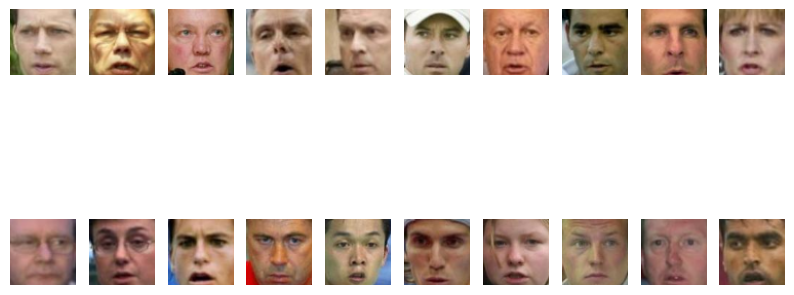

In [ ]:
# Без улыбки
show_images(2, 10, not_smiling_data[0:20], "")

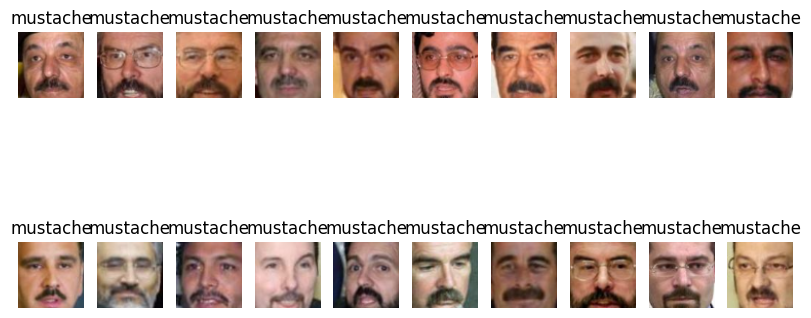

In [ ]:
# с усами
show_images(2, 10, mustache_data[20:40], "mustache")

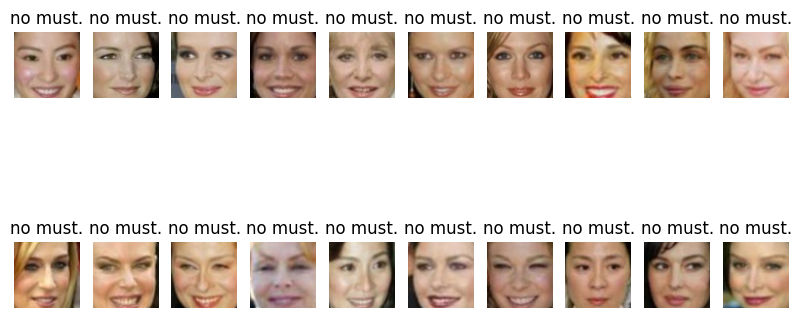

In [ ]:
# без  усов
show_images(2, 10, not_mustache_data[20:40], "no must.")

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

In [ ]:
def calculate_latent_vectors(autoencoder, image_data):
    with torch.no_grad():
        image_tensor = torch.tensor(np.rollaxis(image_data, 3, 1), dtype=torch.float32)
        image_tensor = image_tensor.to(device)
        autoencoder.eval()
        latent_vectors = autoencoder.encode(image_tensor).cpu()
        return latent_vectors

def reconstruct(autoencoder, latent_vectors):
    with torch.no_grad():
        latent_vectors = latent_vectors.to(device)
        autoencoder.eval()
        reconstruction = autoencoder.decode(latent_vectors).cpu()
        return reconstruction


In [ ]:
smiling_l_vectors = calculate_latent_vectors(autoencoder, smiling_data)
smiling_vector = smiling_l_vectors.mean(axis=0)

not_smiling_l_vectors = calculate_latent_vectors(autoencoder, not_smiling_data)
not_smiling_vector = not_smiling_l_vectors.mean(axis=0)

In [ ]:
mustache_l_vectors = calculate_latent_vectors(autoencoder, mustache_data)
mustache_vector = mustache_l_vectors.mean(axis=0)

not_mustache_l_vectors = calculate_latent_vectors(autoencoder, not_mustache_data)
not_mustache_vector = not_mustache_l_vectors.mean(axis=0)

In [ ]:
smile_vector = smiling_vector - not_smiling_vector

In [ ]:
mustache_vector = mustache_vector - not_mustache_vector

In [ ]:
new_not_sml_vectors = not_smiling_l_vectors + smile_vector

In [ ]:
new_not_mustache_vectors = not_mustache_l_vectors + mustache_vector

**Добавим улыбку**

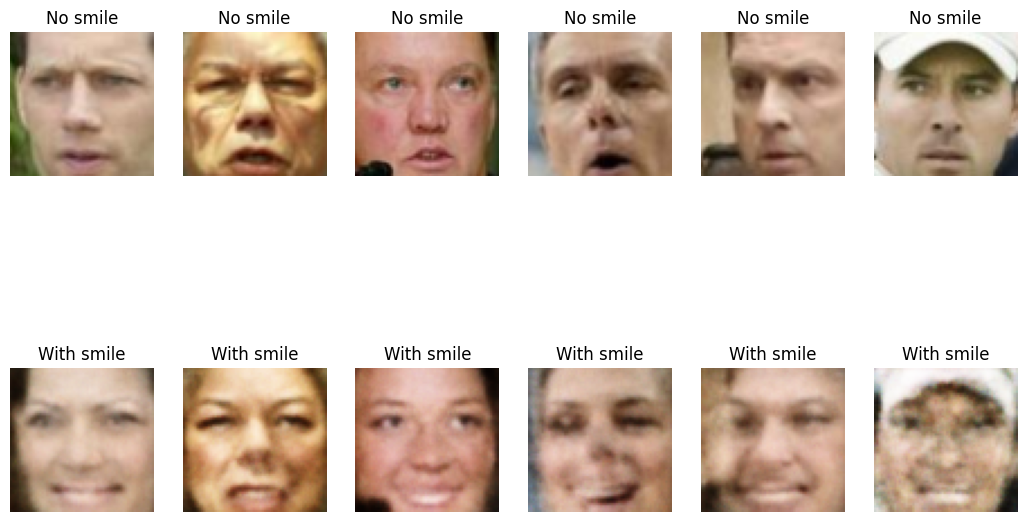

In [ ]:
new_with_smile_images = reconstruct(autoencoder, new_not_sml_vectors)
show_images(2, 6, not_smiling_data[:6], "No smile", new_with_smile_images[:6].numpy(), "With smile", size_x =13, size_y= 8)

Работает, улыбка добавляется!

**Добавим усы**

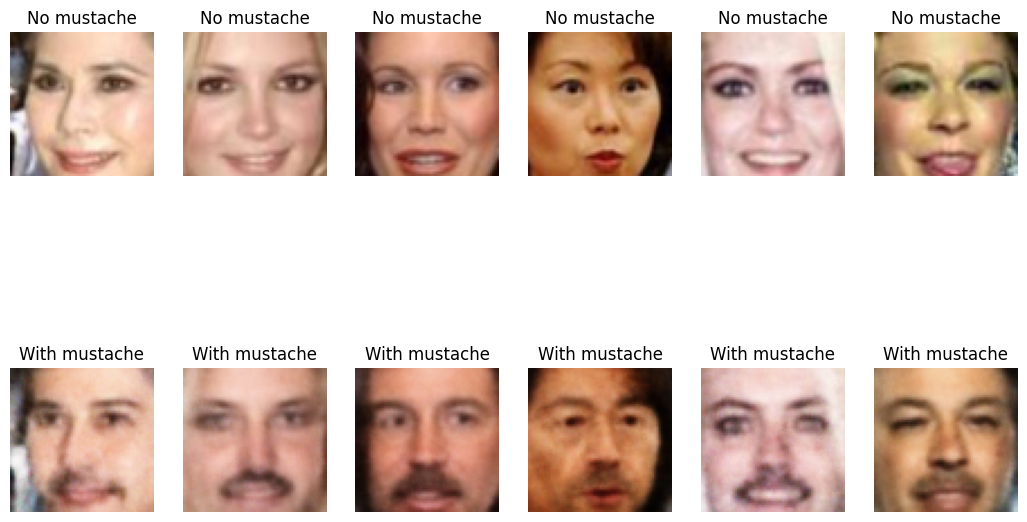

In [ ]:
new_with_mustache_images = reconstruct(autoencoder, new_not_mustache_vectors)
show_images(2, 6, not_mustache_data[:6], "No mustache", new_with_mustache_images[:6].numpy(), "With mustache", size_x =13, size_y= 8)

C усами тоже работает.

**Добавим одновременно усы и улыбку**

In [ ]:
new_not_sml_with_mustache_vectors = new_not_sml_vectors + mustache_vector

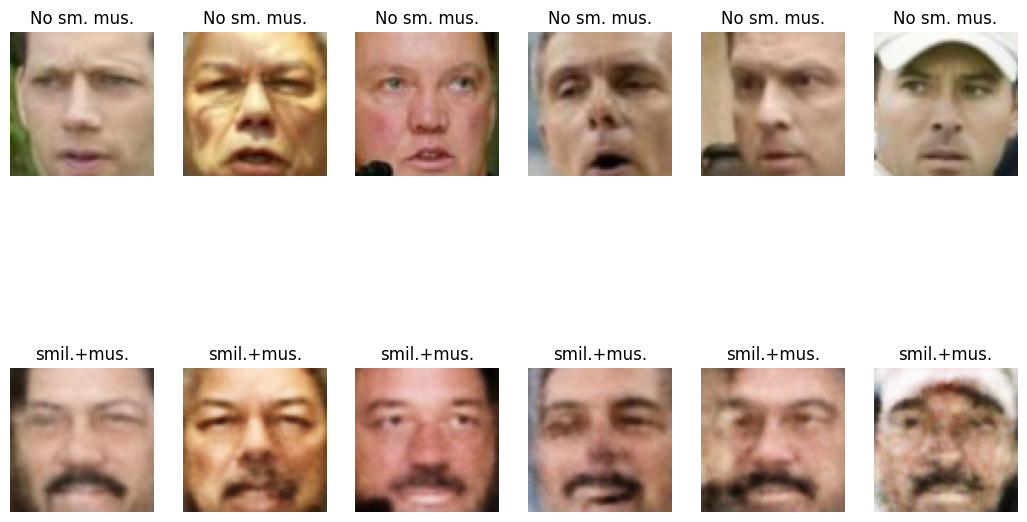

In [ ]:
new_with_smile_mustache_images = reconstruct(autoencoder, new_not_sml_with_mustache_vectors)
show_images(2, 6, not_smiling_data[:6], "No sm. mus.", new_with_smile_mustache_images[:6].numpy(), "smil.+mus.", size_x =13, size_y= 8)

Видно, что работает.

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
# Очистка директории mnist_data
# import shutil
# shutil.rmtree("/kaggle/working/mnist_data")

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset_2 = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset_2 = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# # Data Loader (Input Pipeline)
train_loader_2 = torch.utils.data.DataLoader(dataset=train_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(dataset=test_dataset_2, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 92684381.91it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 124497115.95it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27485896.75it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22760488.37it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim, image_size, num_channels):
        super().__init__()

        self.image_size = image_size

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.mu_fc = nn.Linear(32 * image_size * image_size, latent_dim)
        self.logsigma_fc = nn.Linear(32 * image_size * image_size, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 32 * image_size * image_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_channels, kernel_size=3, padding=1),
        )

    def encode(self, x):
        encoded = self.encoder_conv(x)
        flattened = self.encoder_flatten(encoded)
        mu = self.mu_fc(flattened)
        logsigma = self.logsigma_fc(flattened)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        reconstruction = self.decoder_fc(z)
        reconstruction = reconstruction.view(-1, 32, self.image_size, self.image_size)
        reconstruction = self.decoder(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)

        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    kl = KL_divergence(mu, logsigma)
    lg = log_likelihood(x, reconstruction)
    return kl + lg

In [ ]:
def train_2(train_loader, val_loader, vae, criterion, optimizer, scheduler, epochs):
    train_losses, val_losses = [], []

    if torch.cuda.is_available():
        vae.cuda()

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch + 1, epochs))
        avg_train_loss = 0.0

        vae.train()
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstructed = vae(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item() / len(train_loader)

        train_losses.append(avg_train_loss)

        avg_val_loss = 0.0
        vae.eval()
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                mu, logsigma, reconstructed = vae(X_batch)
                val_loss = criterion(X_batch, mu, logsigma, reconstructed)
                avg_val_loss += val_loss.item() / len(val_loader)

        val_losses.append(avg_val_loss)
        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        show_images(2, 5, X_batch[:5].cpu().numpy(), "real", reconstructed[:5].cpu().numpy(), "reconstructed", plt_title='%d / %d - loss: %f' % (epoch + 1, epochs, avg_train_loss))

        plt.figure(figsize=(20, 10))
        plt.plot(range(1, epoch + 2), train_losses, label="train_loss")
        plt.plot(range(1, epoch + 2), val_losses, label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

        del X_batch
        del reconstructed
        del mu
        del logsigma
        del loss
        del val_loss
        torch.cuda.empty_cache()

In [ ]:
def predict_2(vae, val_loader):
    reconstructions, mus, logsigmas = [], [], []
    vae.eval()
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            mu, logsigma, reconstructed = vae(X_batch)
            reconstructions.append(reconstructed.cpu())
            mus.append(mu.cpu())
            logsigmas.append(logsigma.cpu())

    return torch.cat(reconstructions), torch.cat(mus), torch.cat(logsigmas)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder_vae = VAE(dim_code, 28, 1).to(device)

optimizer = optim.Adam(autoencoder_vae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

In [ ]:
max_epochs_vae = 18

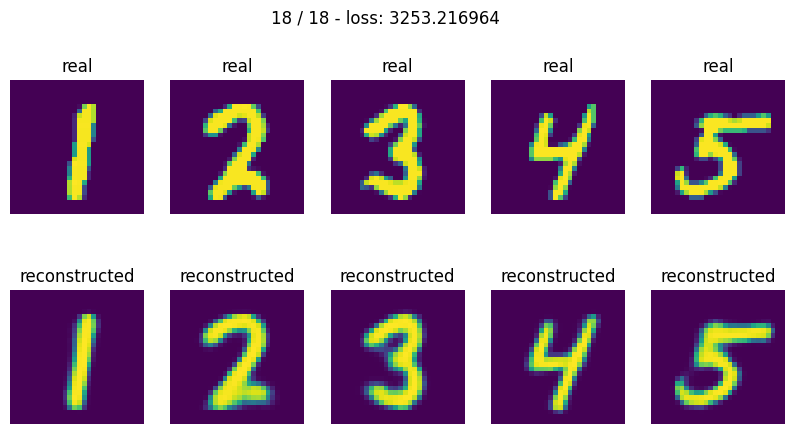

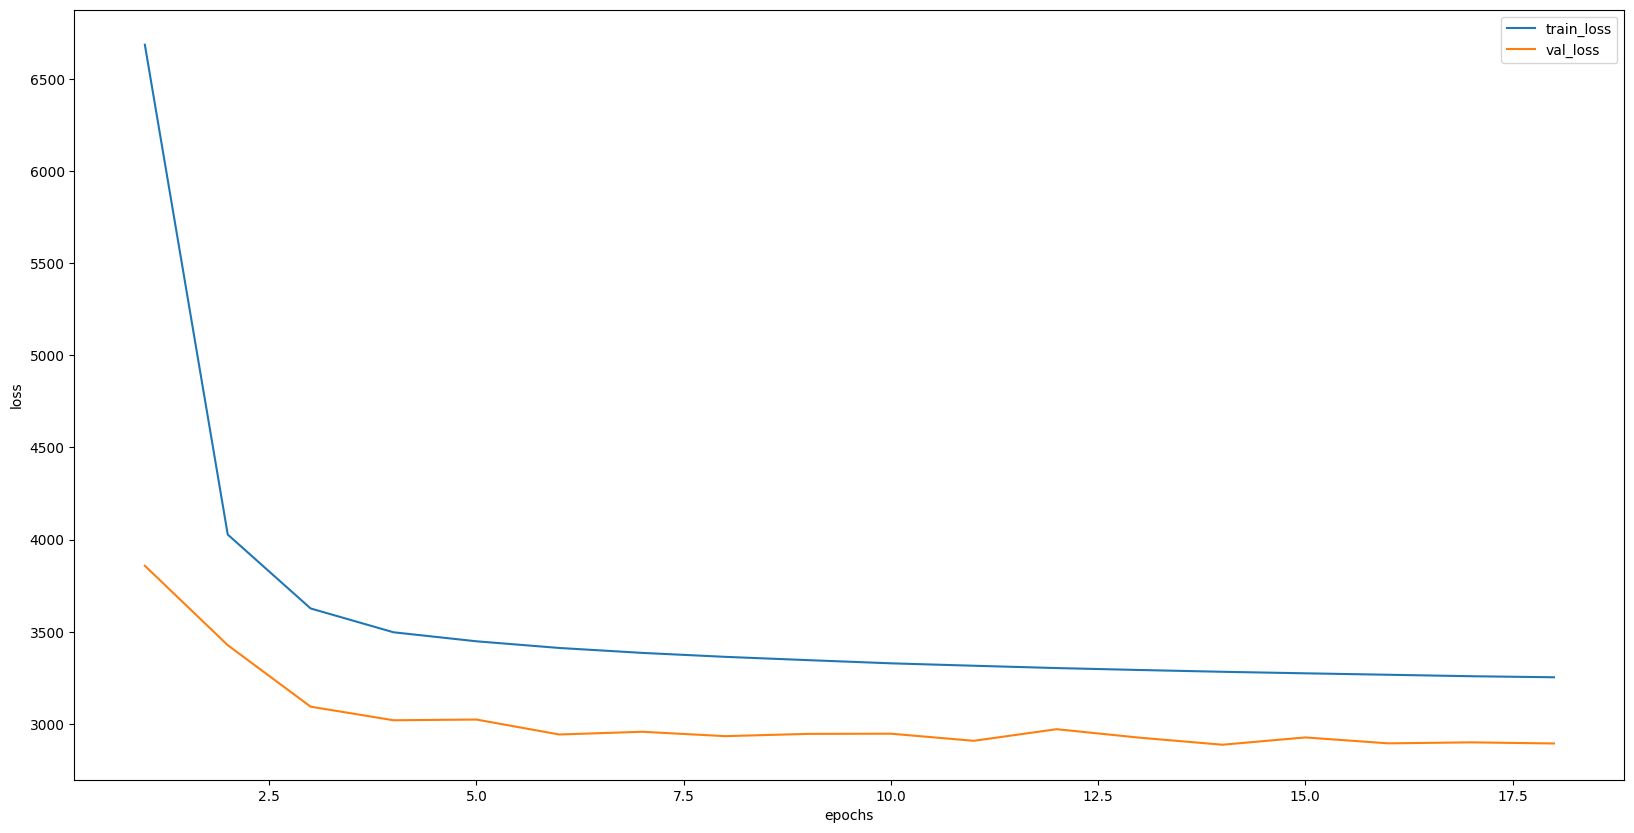

In [ ]:
train_2(train_loader_2 , test_loader_2, autoencoder_vae, criterion, optimizer, scheduler, max_epochs_vae)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
reconstructed, mus, logsigmas = predict_2(autoencoder_vae, test_loader_2)
real_data_mnist = next(iter(test_loader_2))[0]

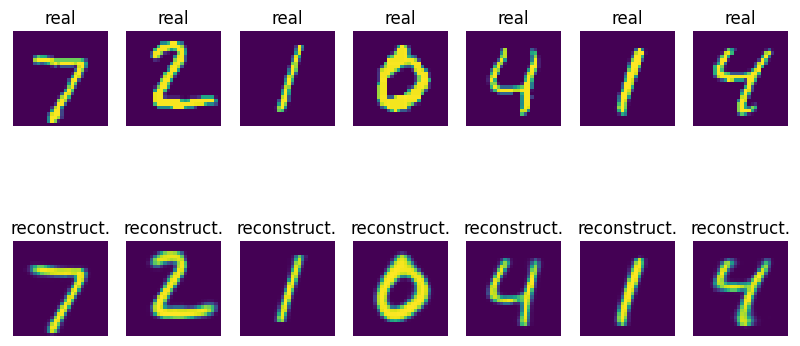

In [ ]:
show_images(2, 7, real_data_mnist[:7].numpy(), "real", reconstructed[:7].numpy(), "reconstruct.")

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
z = torch.tensor(z, dtype=torch.float32).to(device)
output = autoencoder_vae.decode(z)

Посмотрим, какие картинки получаются:

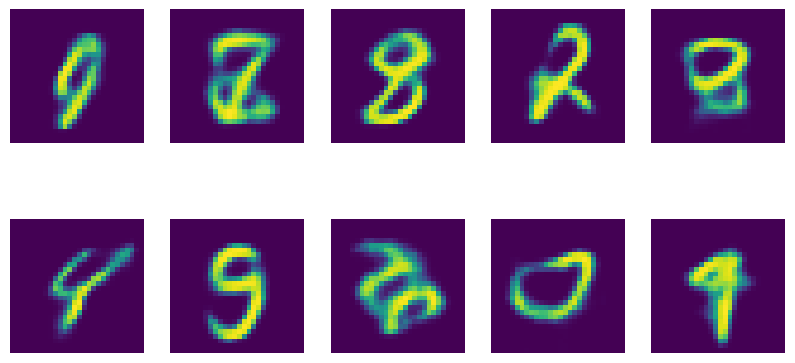

In [ ]:
show_images(2, 5, output[:10].cpu().detach().numpy())

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# Применим TSNE is a popular dimensionality reduction technique
mus_2 = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))

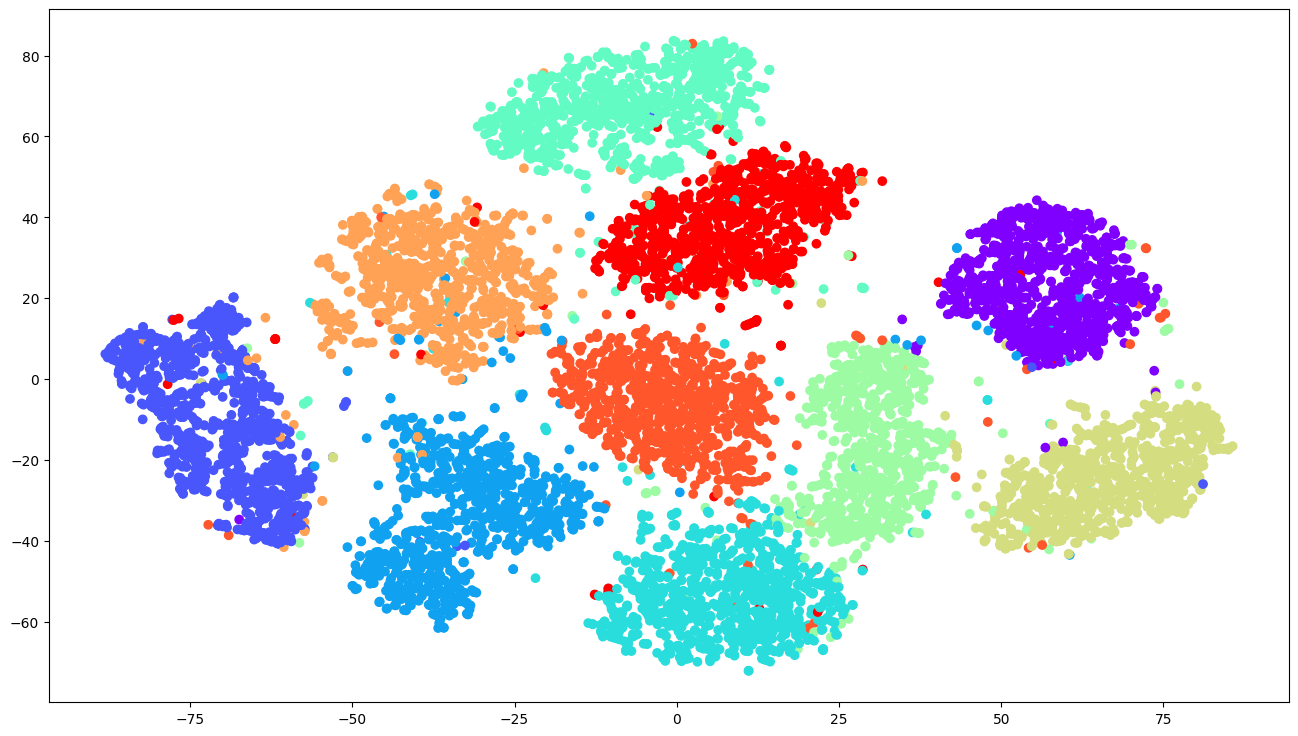

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(mus_2[:, 0], mus_2[:, 1], c=test_dataset_2.targets, cmap='rainbow')

Что вы думаете о виде латентного представления?

Латентные представления хорошо разбились по кластерам.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.

На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )


        self.mu_fc = nn.Linear(256, latent_dim)
        self.logsigma_fc = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
        )

    def encode(self, x, class_num):
        flattened = self.encoder_flatten(x)
        flattened = torch.cat((flattened, class_num), dim=1)
        encoded = self.encoder(flattened)

        mu = self.mu_fc(encoded)
        logsigma = self.logsigma_fc(encoded)

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        reconstruction = torch.cat((z, class_num), dim=1)
        reconstruction = self.decoder(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        return reconstruction

    def forward(self, x, class_num):
        y = nn.functional.one_hot(class_num, 10)
        mu, logsigma, class_num = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)

        return mu, logsigma, reconstruction

In [ ]:
def train_3(train_loader, val_loader, cvae, criterion, optimizer, scheduler, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch + 1, epochs))
        avg_train_loss = 0.0

        cvae.train()
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstructed = cvae(X_batch, Y_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item() / len(train_loader)

        train_losses.append(avg_train_loss)

        avg_val_loss = 0.0
        cvae.eval()
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                mu, logsigma, reconstructed = cvae(X_batch, Y_batch)
                val_loss = criterion(X_batch, mu, logsigma, reconstructed)
                avg_val_loss += val_loss.item() / len(val_loader)

        val_losses.append(avg_val_loss)
        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        show_images(2, 5, X_batch[:5].cpu().numpy(), "real", reconstructed[:5].cpu().numpy(), \
                    "reconstructed", plt_title='%d / %d - loss: %f' % (epoch + 1, epochs, avg_train_loss))

        plt.figure(figsize=(20, 10))
        plt.plot(range(1, epoch + 2), train_losses, label="train_loss")
        plt.plot(range(1, epoch + 2), val_losses, label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

        del X_batch
        del Y_batch
        del reconstructed
        del mu
        del logsigma
        del loss
        del val_loss
        torch.cuda.empty_cache()

In [ ]:
def predict_3(cvae, val_loader):
    reconstructions, mus, logsigmas = [], [], []
    cvae.eval()
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            mu, logsigma, reconstructed = cvae(X_batch, Y_batch)
            reconstructions.append(reconstructed.cpu())
            mus.append(mu.cpu())
            logsigmas.append(logsigma.cpu())

    return torch.cat(reconstructions), torch.cat(mus), torch.cat(logsigmas)

In [ ]:
max_epochs_cvae = 18

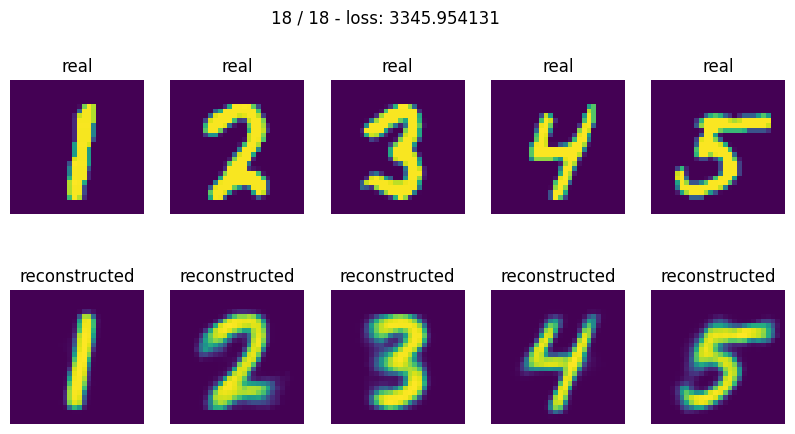

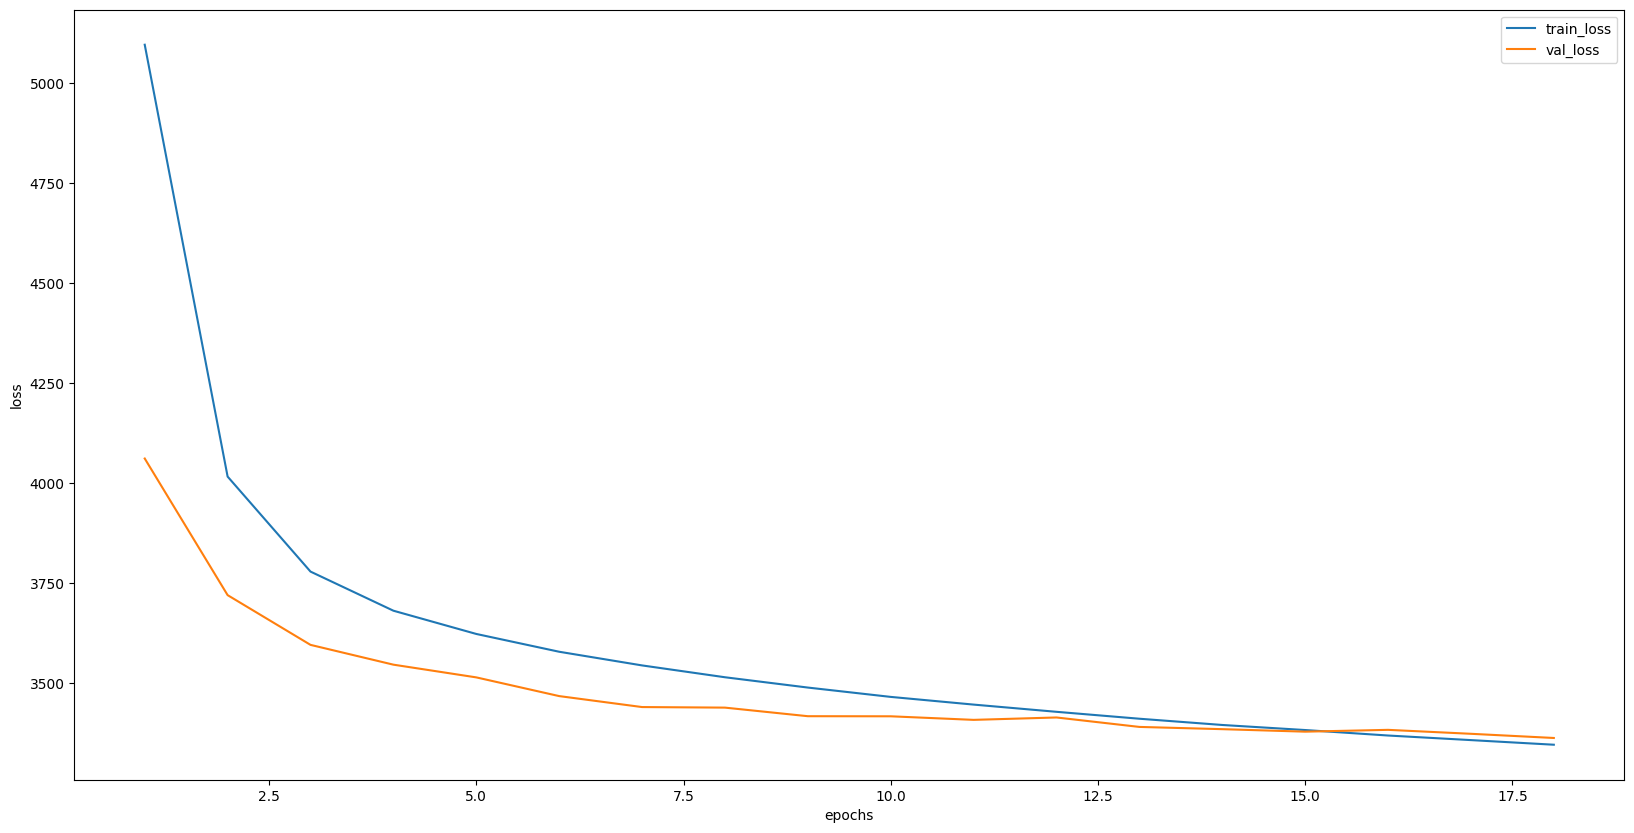

In [ ]:
criterion = loss_vae

autoencoder_cvae = CVAE(dim_code).to(device)

optimizer = optim.Adam(autoencoder_cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

train_3(train_loader_2 , test_loader_2, autoencoder_cvae, criterion, optimizer, scheduler, max_epochs_cvae)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
reconstructed, mus_cvae, logsigmas = predict_3(autoencoder_cvae, test_loader_2)
real_data_mnist = next(iter(test_loader_2))[0]

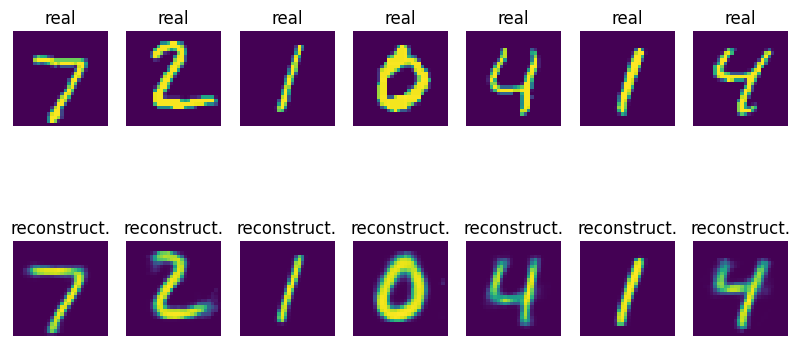

In [ ]:
show_images(2, 7, real_data_mnist[:7].numpy(), "real", reconstructed[:7].numpy(), "reconstruct.")

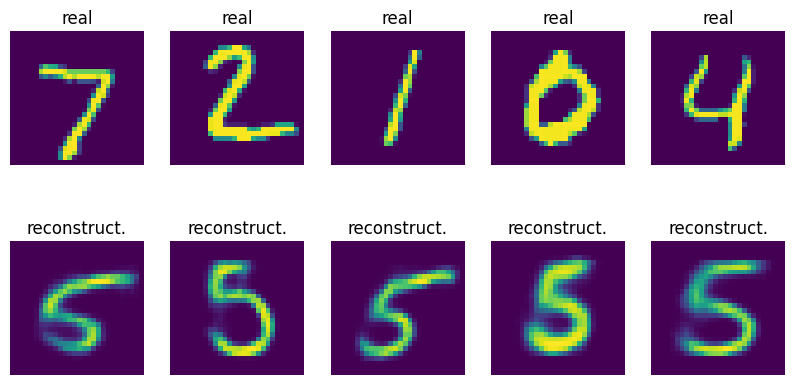

In [ ]:
# засемплируем латентные векторы изображений с классом 5.
autoencoder_cvae.eval()
y = nn.functional.one_hot(torch.LongTensor([5]), 10).view(1, -1)
with torch.no_grad():
    reconstruct = np.array([autoencoder_cvae.decode(mus_cvae[i].view(1, -1).to(device), y.to(device)).cpu().numpy() for i in range(5)]).squeeze()

show_images(2, 5, real_data_mnist[:5].numpy(), "real", reconstruct[:5], "reconstruct.")

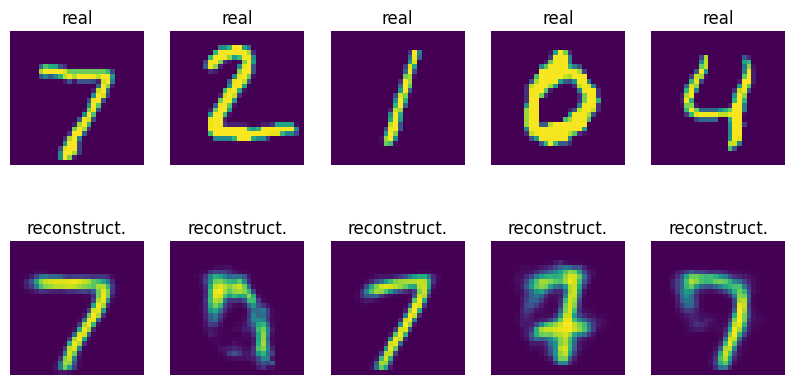

In [ ]:
# засемплируем латентные векторы с классом 7.
autoencoder_cvae.eval()
y = nn.functional.one_hot(torch.LongTensor([7]), 10).view(1, -1)
with torch.no_grad():
    reconstruct = np.array([autoencoder_cvae.decode(mus_cvae[i].view(1, -1).to(device), y.to(device)).cpu().numpy() for i in range(5)]).squeeze()

show_images(2, 5, real_data_mnist[:5].numpy(), "real", reconstruct[:5], "reconstruct.")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
mus_cvae_tsne = torch.from_numpy(TSNE(n_components=2).fit_transform(mus_cvae))

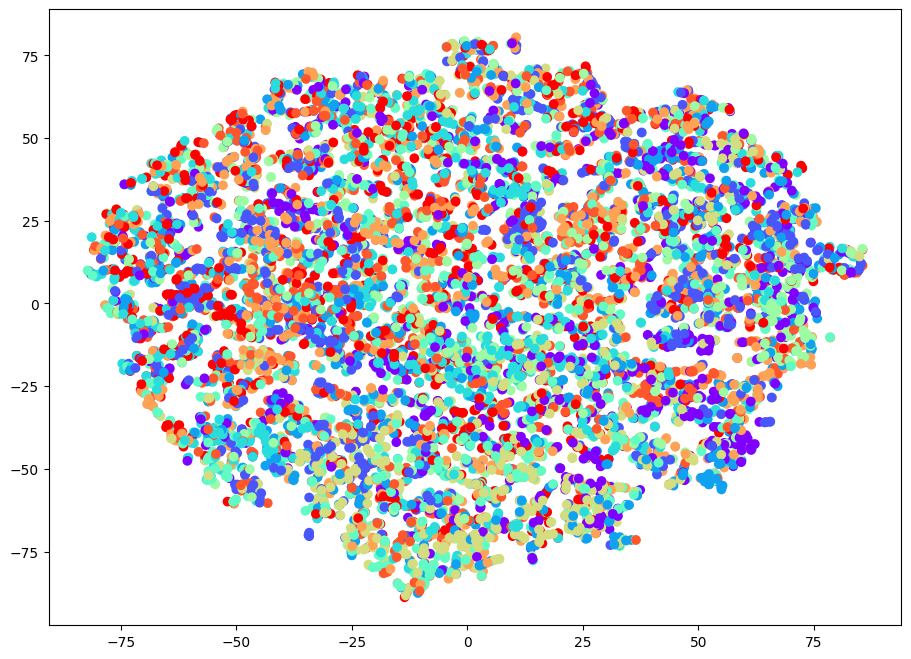

In [ ]:
plt.figure(figsize=(11, 8))
plt.scatter(mus_cvae_tsne[:, 0], mus_cvae_tsne[:, 1], c=test_dataset_2.targets, cmap='rainbow')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Картинка от VAE отличается существенно.  В сравнении с VAE, у которого латентные представления хорошо разбились по кластерам.    
У  Conditional VAE латентные векторы перемешаны, не распределены по кластерам. Это связано с тем, что  мы вместе с картинкой передаем в CVAE еще информацию о классе картинки.